In [115]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
import geopandas  as gp
import folium
from folium import plugins
import warnings
warnings.filterwarnings('ignore')
print("Setup Complete")

Setup Complete


## Understanding and Cleaning the Data

In [116]:
df = pd.read_csv("/kaggle/input/new-york-housing-market/NY-House-Dataset.csv")
df.head()

,BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
0,Brokered by Douglas Elliman -111 Fifth Ave,Condo for sale,315000,2,2.000000,1400.0,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483
1,Brokered by Serhant,Condo for sale,195000000,7,10.000000,17545.0,Central Park Tower Penthouse-217 W 57th New Yo...,"New York, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,United States,New York,New York County,New York,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991
2,Brokered by Sowae Corp,House for sale,260000,4,2.000000,2015.0,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109
3,Brokered by COMPASS,Condo for sale,69000,3,1.000000,445.0,2 E 55th St Unit 908W33,"Manhattan, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",United States,New York,New York County,New York,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613
4,Brokered by Sotheby's International Realty - E...,Townhouse for sale,55000000,7,2.373861,14175.0,5 E 64th St,"New York, NY 10065","5 E 64th StNew York, NY 10065",United States,New York,New York County,New York,East 64th Street,"5 E 64th St, New York, NY 10065, USA",40.767224,-73.969856


In [117]:
df.describe()

,PRICE,BEDS,BATH,PROPERTYSQFT,LATITUDE,LONGITUDE
count,4.801000e+03,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000
mean,2.356940e+06,3.356801,2.373861,2184.207862,40.714227,-73.941601
std,3.135525e+07,2.602315,1.946962,2377.140894,0.087676,0.101082
min,2.494000e+03,1.000000,0.000000,230.000000,40.499546,-74.253033
25%,4.990000e+05,2.000000,1.000000,1200.000000,40.639375,-73.987143
50%,8.250000e+05,3.000000,2.000000,2184.207862,40.726749,-73.949189
75%,1.495000e+06,4.000000,3.000000,2184.207862,40.771923,-73.870638
max,2.147484e+09,50.000000,50.000000,65535.000000,40.912729,-73.702450


In [118]:
df.shape

(4801, 17)

In [119]:
df.columns

Index(['BROKERTITLE', 'TYPE', 'PRICE', 'BEDS', 'BATH', 'PROPERTYSQFT',
       'ADDRESS', 'STATE', 'MAIN_ADDRESS', 'ADMINISTRATIVE_AREA_LEVEL_2',
       'LOCALITY', 'SUBLOCALITY', 'STREET_NAME', 'LONG_NAME',
       'FORMATTED_ADDRESS', 'LATITUDE', 'LONGITUDE'],
      dtype='object')

In [120]:
df.isnull().sum()

BROKERTITLE                    0
TYPE                           0
PRICE                          0
BEDS                           0
BATH                           0
PROPERTYSQFT                   0
ADDRESS                        0
STATE                          0
MAIN_ADDRESS                   0
ADMINISTRATIVE_AREA_LEVEL_2    0
LOCALITY                       0
SUBLOCALITY                    0
STREET_NAME                    0
LONG_NAME                      0
FORMATTED_ADDRESS              0
LATITUDE                       0
LONGITUDE                      0
dtype: int64

In [121]:
df.duplicated().sum()

214

In [122]:
df=df.drop_duplicates()

Removing prefixes and suffixes

In [123]:
df["BROKERTITLE"] = df["BROKERTITLE"].apply(lambda row: row.removeprefix("Brokered by "))
df["TYPE"] = df["TYPE"].apply(lambda row: row.removesuffix(" for sale"))

In [124]:
#renaming columns for easier approach
df = df.rename(columns={"TYPE": "type",
                   "BROKERTITLE": "broker",
                   "PRICE": "price",
                   "BEDS": "beds",
                   "BATH": "baths",
                   "PROPERTYSQFT": "sqft",
                   "ADDRESS": "address",
                   "STATE": "state",
                   "MAIN_ADDRESS": "address_full",
                   "LATITUDE": "lat",
                   "LONGITUDE": "lon",
                   "SUBLOCALITY": "sub_locality"})[["type", "broker", "price", "beds", "baths", "sqft", 
                                                    "address", "state", "address_full", "lat", "lon",
                                                    "sub_locality"]]

In [125]:
df["baths"] = df["baths"].astype("int32")

##### Note:
After reading many noteboks that used this data, it turns out the the sub_locality values are inconsistent, so this converts them all on county level

In [126]:
tranlations = {
    "New York": "New York County",  # Generally refers to Manhattan
    "Kings County": "Kings County",  # Brooklyn
    "Queens County": "Queens County",
    "Queens": "Queens County",
    "Richmond County": "Richmond County",  # Staten Island
    "Brooklyn": "Kings County",
    "Bronx County": "Bronx County",
    "New York County": "New York County",  # Manhattan
    "The Bronx": "Bronx County",
    "Staten Island": "Richmond County",
    "Manhattan": "New York County",
    "Riverdale": "Bronx County",  # Neighborhood in The Bronx
    "Flushing": "Queens County",  # Neighborhood in Queens
    "Coney Island": "Kings County",  # Neighborhood in Brooklyn
    "East Bronx": "Bronx County",  # Part of The Bronx
    "Brooklyn Heights": "Kings County",  # Neighborhood in Brooklyn
    "Jackson Heights": "Queens County",  # Neighborhood in Queens
    "Rego Park": "Queens County",  # Neighborhood in Queens
    "Fort Hamilton": "Kings County",  # Neighborhood in Brooklyn
    "Dumbo": "Kings County",  # Neighborhood in Brooklyn
    "Snyder Avenue": "Kings County"  # Assuming this is in Brooklyn; otherwise, needs correction
}

df["sub_locality"] = df["sub_locality"].apply(lambda row: tranlations[row])

In [127]:
np.any(~df["sub_locality"].str.contains("County"))

False

##### dealing with outliers

In [128]:
df.sort_values(by="beds", ascending=False).head(10)

,type,broker,price,beds,baths,sqft,address,state,address_full,lat,lon,sub_locality
1143,Multi-family home,Blue Key Real Estate Brokerage,11000000,50,50,22035.0,8820 Avenue J,"Brooklyn, NY 11236","8820 Avenue JBrooklyn, NY 11236",40.637696,-73.904836,Kings County
2653,Multi-family home,NEUHAUS REALTY INC.,10700000,42,43,27152.0,646-662 Port Richmond Ave,"Staten Island, NY 10302","646-662 Port Richmond AveStaten Island, NY 10302",40.627671,-74.142352,Richmond County
3276,Multi-family home,Weichert Realtors TMT Group,5980000,40,20,15500.0,35-54 95th St,"Jackson Heights, NY 11372","35-54 95th StJackson Heights, NY 11372",40.751468,-73.872619,Queens County
2488,Multi-family home,RE MAX Real Estate Professionals,3099000,36,16,12460.0,5206 6th Ave,"Brooklyn, NY 11220","5206 6th AveBrooklyn, NY 11220",40.642652,-74.009674,Kings County
765,Multi-family home,RE MAX Edge,4380000,35,16,15000.0,8699 Bay Pkwy Unit 16,"Brooklyn, NY 11214","8699 Bay Pkwy Unit 16Brooklyn, NY 11214",40.599715,-73.995694,Kings County
2265,House,Coldwell Banker Reliable,4000000,32,12,7188.0,150 E 105th St,"New York, NY 10029","150 E 105th StNew York, NY 10029",40.791288,-73.946522,New York County
3589,Multi-family home,Coldwell Banker Reliable Real Estate,4000000,32,12,7200.0,154 E 105th St,"New York, NY 10029","154 E 105th StNew York, NY 10029",40.791206,-73.946512,New York County
3603,Multi-family home,BHHS Fillmore R.E.,3500000,30,20,18400.0,1319 Newkirk Ave,"Brooklyn, NY 11230","1319 Newkirk AveBrooklyn, NY 11230",40.635180,-73.964614,Kings County
2564,Multi-family home,Coldwell Banker American Homes,2700000,24,24,18936.0,3520 Newkirk Ave Unit 24,"Brooklyn, NY 11203","3520 Newkirk Ave Unit 24Brooklyn, NY 11203",40.640181,-73.942939,Kings County
1092,House,CHRISTIE'S INT.REAL ESTATE GROUP,3500000,24,8,9500.0,29 Hampton Pl,"Brooklyn, NY 11213","29 Hampton PlBrooklyn, NY 11213",40.671795,-73.940735,Kings County


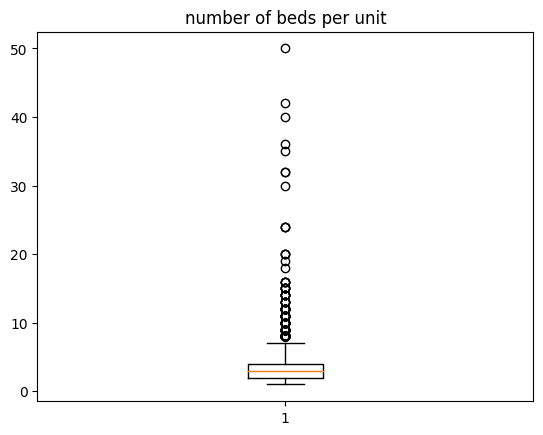

In [129]:
plt.boxplot(df["beds"])
plt.title("number of beds per unit")
plt.show()

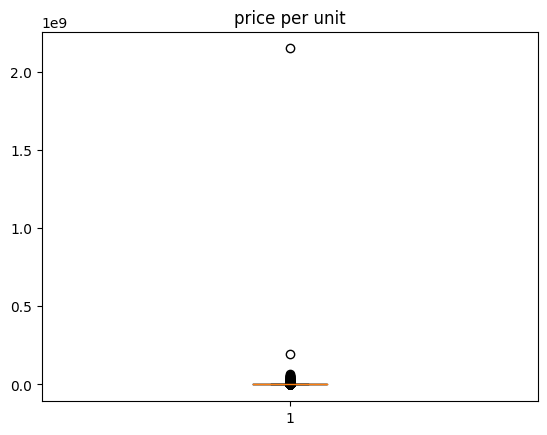

In [130]:
plt.boxplot(df["price"])
plt.title("price per unit")
plt.show()

In [131]:
df.sort_values(by="price", ascending=False).head(10)

,type,broker,price,beds,baths,sqft,address,state,address_full,lat,lon,sub_locality
304,House,ANNE LOPA REAL ESTATE,2147483647,7,6,10000.000000,6659-6675 Amboy Rd,"New York, NY 10309","6659-6675 Amboy RdNew York, NY 10309",40.518484,-74.224418,Richmond County
1,Condo,Serhant,195000000,7,10,17545.000000,Central Park Tower Penthouse-217 W 57th New Yo...,"New York, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,40.766393,-73.980991,New York County
69,Townhouse,Sotheby's International Realty - East Side Man...,65000000,3,2,15200.000000,4 E 79th St,"New York, NY 10075","4 E 79th StNew York, NY 10075",40.776561,-73.963317,New York County
1075,Co-op,COMPASS,60000000,8,8,2184.207862,960 5th Ave Unit 12,"Manhattan, NY 10075","960 5th Ave Unit 12Manhattan, NY 10075",40.775642,-73.964247,New York County
141,House,Douglas Elliman - 575 Madison Ave,56000000,11,10,24000.000000,9 W 54th St,"New York, NY 10019","9 W 54th StNew York, NY 10019",40.761600,-73.976191,New York County
99,House,Douglas Elliman - 575 Madison Ave,55000000,8,8,12000.000000,25 Riverside Dr,"New York, NY 10023","25 Riverside DrNew York, NY 10023",40.782238,-73.984632,New York County
4,Townhouse,Sotheby's International Realty - East Side Man...,55000000,7,2,14175.000000,5 E 64th St,"New York, NY 10065","5 E 64th StNew York, NY 10065",40.767224,-73.969856,New York County
626,Condo,"Nest Seekers International, Midtown",50000000,6,6,6569.000000,100 Vandam St Apt 20A,"New York, NY 10013","100 Vandam St Apt 20ANew York, NY 10013",40.726633,-74.008832,New York County
1453,Co-op,Corcoran East Side,48000000,5,2,2184.207862,740 Park Ave # 4 & 5B,"New York, NY 10021","740 Park Ave # 4 & 5BNew York, NY 10021",40.770752,-73.964528,New York County
3388,Co-op,Sotheby's International Realty - East Side Man...,45000000,5,2,2184.207862,4 E 66th St Fl 7,"New York, NY 10065","4 E 66th St Fl 7New York, NY 10065",40.768301,-73.969734,New York County


The notebook that i used for reference googled this listing to make sure its right ([here](https://www.zillow.com/homedetails/6659-6675-Amboy-Rd-Staten-Island-NY-10309/2055078546_zpid/) and turns out its just scraped wrong

In [132]:
df = df.drop(1143)
df["price"][304] = 2290700
df["price"][1] = 19500000

In [133]:
df[["sub_locality", "price"]].groupby("sub_locality").agg(["min", "max", "std", "mean", "median"])

price                                                 
                    min       max           std          mean     median
sub_locality                                                            
Bronx County      49500  14000000  1.027218e+06  7.624211e+05   599000.0
Kings County       5800  31500000  1.928083e+06  1.439236e+06   949000.0
New York County    2494  65000000  7.010165e+06  4.081857e+06  1479000.0
Queens County    100000  15000000  8.013789e+05  8.243145e+05   669000.0
Richmond County   90000  16800000  1.003193e+06  8.912633e+05   728000.0

In [134]:
df.describe()

,price,beds,baths,sqft,lat,lon
count,4.586000e+03,4586.000000,4586.000000,4586.000000,4586.000000,4586.000000
mean,1.873254e+06,3.355648,2.343873,2173.382446,40.713949,-73.941592
std,4.087458e+06,2.537266,1.840932,2264.429959,0.087740,0.101286
min,2.494000e+03,1.000000,0.000000,230.000000,40.499546,-74.253033
25%,4.990000e+05,2.000000,1.000000,1200.000000,40.638624,-73.987431
50%,8.250000e+05,3.000000,2.000000,2184.207862,40.726691,-73.949146
75%,1.497250e+06,4.000000,3.000000,2184.207862,40.771913,-73.869418
max,6.500000e+07,42.000000,43.000000,65535.000000,40.912729,-73.702450


In [135]:
df.head()

,type,broker,price,beds,baths,sqft,address,state,address_full,lat,lon,sub_locality
0,Condo,Douglas Elliman -111 Fifth Ave,315000,2,2,1400.0,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",40.761255,-73.974483,New York County
1,Condo,Serhant,19500000,7,10,17545.0,Central Park Tower Penthouse-217 W 57th New Yo...,"New York, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,40.766393,-73.980991,New York County
2,House,Sowae Corp,260000,4,2,2015.0,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",40.541805,-74.196109,Richmond County
3,Condo,COMPASS,69000,3,1,445.0,2 E 55th St Unit 908W33,"Manhattan, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",40.761398,-73.974613,New York County
4,Townhouse,Sotheby's International Realty - East Side Man...,55000000,7,2,14175.0,5 E 64th St,"New York, NY 10065","5 E 64th StNew York, NY 10065",40.767224,-73.969856,New York County


### Splitting, predicting, and evaluating
using 5 different models

In [136]:
X = df.drop(columns="price")
y = df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                                random_state=0)

In [137]:
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object']).columns

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# pipeline for nums and cats
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

In [138]:
model1 = RandomForestRegressor(n_estimators=100, random_state=0)
model2 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)
model3 = LinearRegression()
model4 = SVR(C=0.1, coef0=2.0, gamma=1, kernel='poly')
model5 = ElasticNet(random_state=10)

In [139]:
# making an ensemble model using VotingRegressor
ensemble_model = VotingRegressor(estimators=[
    ('rf', model1), 
    ('gb', model2), 
    ('lr', model3), 
    ('sr', model4), 
    ('en', model5)])

ensemble_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('model', ensemble_model)
                                    ])

ensemble_pipeline.fit(X_train, y_train)

#get predictions
ensemble_preds = ensemble_pipeline.predict(X_test)

In [140]:
ensemble_score = mean_absolute_error(y_test, ensemble_preds)
print('Ensemble MAE:', ensemble_score)

Ensemble MAE: 854474.2938679678


previous versions of this notebook had worse MAE score using different methods, so i consider this score great!

### doing some cool geo analysis

In [141]:
map = folium.Map(location=[df.lat.mean(), df.lon.mean()], zoom_start=11.4)

MAX = np.log(df.price.max())
hm = plugins.HeatMap([[row["lat"], row["lon"], np.log(row["price"])/MAX] for index, row in df.iterrows()],
                     gradient={0.85: 'blue', 0.95: 'lime', 1: 'red'})

hm.add_to(map)

map